### CIQ Scraper Workbook

##### 1. Statement

This workbook is an illustration on extracting, formulating, and exporting companies' sustainability information from CDP database. The following codes are only for internal use of ABB's consulting practicum project and research purpose. For more details of the data source, please refer to https://www.cdp.net/en/data.

Reminders from CDP website: Those works are protected by copyright laws and treaties around the world. You may not use, copy, reproduce or licenses that we offer for the use of our intellectual property. modify any content from our site without our permission. You may contact us here (https://www.cdp.net/en/data.) to discuss the licenses that we offer for the use of our intellectual property.

Each free account has a limited quota of 10 entries. That means each free account can only visit 10 companies' sustainabiity data in one time.

##### 2. Code

In [3]:
def show_screen():
    bot.save_screenshot("out.png")
    display(Image("out.png"))

In [4]:
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
import pandas as pd
import lxml
import getpass
from IPython.display import display, Image
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from fake_useragent import UserAgent

In [6]:
ua = UserAgent()
user_agent = ua.random
user_agent

'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/116.0'

In [7]:
options = webdriver.ChromeOptions()
options.add_argument('--no-sandbox')
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--disable-dve-shm-uage')
options.add_argument('ignore-certificate-errors')
options.add_argument('--ignore-ssl-errors=yes')
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument(f'user-agent={user_agent}')

##### 2.1 *page_login()*

To get access the CDP database, users are required to specify their usernames and passwords before creating a webdriver object (or 'bot'). 

In [8]:
username = 'bensshieh21@proton.me'
password = 'kCT$!7Tzaw4cFJK'

In [17]:
def page_login():
    url = 'https://cdpidentity.b2clogin.com/cdpidentity.onmicrosoft.com/b2c_1_sign_up_sign_in/oauth2/v2.0/authorize?client_id=ad478c7f-6065-407a-87b2-57ea37ea3642&nonce=3b72efeeb0be15f40e9fb8fb4b331383&redirect_uri=https%3A%2F%2Fwww.cdp.net%2Fauth%2Fazure_activedirectory_v2%2Fcallback&response_type=code&scope=openid%20offline_access%20ad478c7f-6065-407a-87b2-57ea37ea3642&state=0ef940e08f379175ba1b8f0f69a10562&ui_locales=en'
    
    ua = UserAgent()
    user_agent = ua.random

    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-gpu')
    options.add_argument('--disable-dve-shm-uage')
    options.add_argument('ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors=yes')
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument(f'user-agent={user_agent}')

    
    bot = webdriver.Chrome(options=options) # options=options
    wait = WebDriverWait(bot, 20)
    bot.get(url)
    try:
        wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "#onetrust-accept-btn-handler"))).click()
    except Exception:
        pass
    time.sleep(1)

    bot.find_element(By.ID, 'email').send_keys(username)
    bot.find_element(By.ID, 'password').send_keys(password)
    button = bot.find_element(By.CSS_SELECTOR, "button[type='submit']")
    button.click()
    time.sleep(1)

    return bot

In [27]:
bot = page_login()

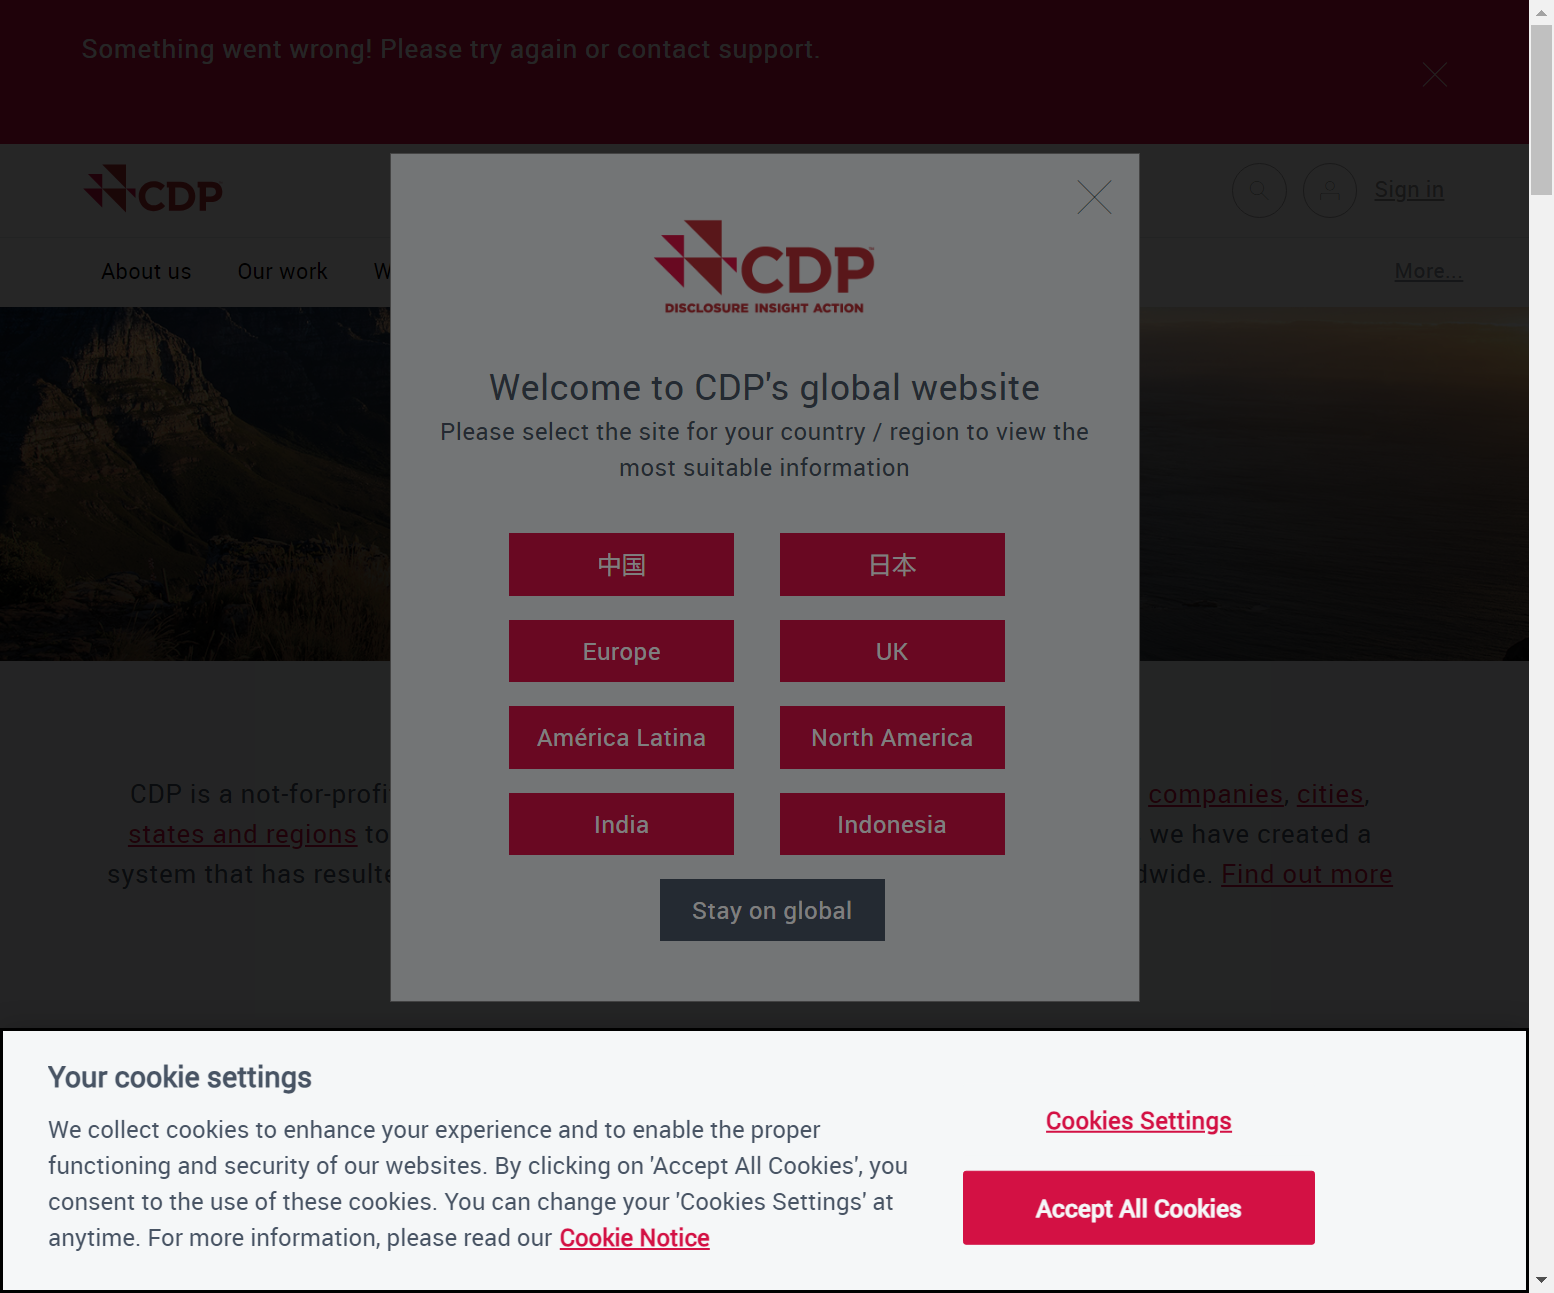

In [19]:
show_screen()

##### 2.2 *search_company(bot, company_name)*

CDP provides a search engine with its users such that by searching the entire company name users can visit the company's annual sustainability questionnaires in terms of climate change, forest, and water security.

To simulate such searching on this bot object, users need to specify the `bot` and `company_name`. Notice that this search engine provides a fuzzy match, so to obtain precise company data, we suggest users refer to the `company_name_cdp` column in `master_excel_all_variables.xlsx`.

In [31]:
def search_company(bot, company_name):

    time.sleep(5)

    bot.get('https://www.cdp.net/en/scores')

    try:
        wait = WebDriverWait(bot, 20)
        wait.until(EC.visibility_of_element_located((By.CSS_SELECTOR, "#onetrust-accept-btn-handler"))).click()
    except Exception:
        pass

    try:
        popup_button = WebDriverWait(bot, 5).until(
            EC.presence_of_element_located((By.CLASS_NAME, "ga-track-regional-popup-item-north-america"))
        )
        popup_button.click()
        time.sleep(1)  # Waiting for 1 second after the click

    except TimeoutException:
        pass  # If the button does not appear, do nothing and continue

    # popup_button = bot.find_element(By.CLASS_NAME, "ga-track-regional-popup-item-north-america")
    # popup_button.click()
    # time.sleep(1)

    input_box = bot.find_element(By.ID, "queries_name")
    input_box.send_keys(company_name)
    submit_button = bot.find_element(By.CLASS_NAME, "response_search_form--btn")
    submit_button.click()

    link = bot.find_element(By.CSS_SELECTOR, "a.pagination__per_page--selected")
    href = link.get_attribute('href')
    href = href.replace('page=5', 'page=20')
    bot.get(href)

    time.sleep(5)

    return bot

Example: Searching for the sustainability questionnaires of ADM

In [25]:
company_name = 'Archer Daniels Midland'

In [32]:
bot = search_company(bot, company_name)

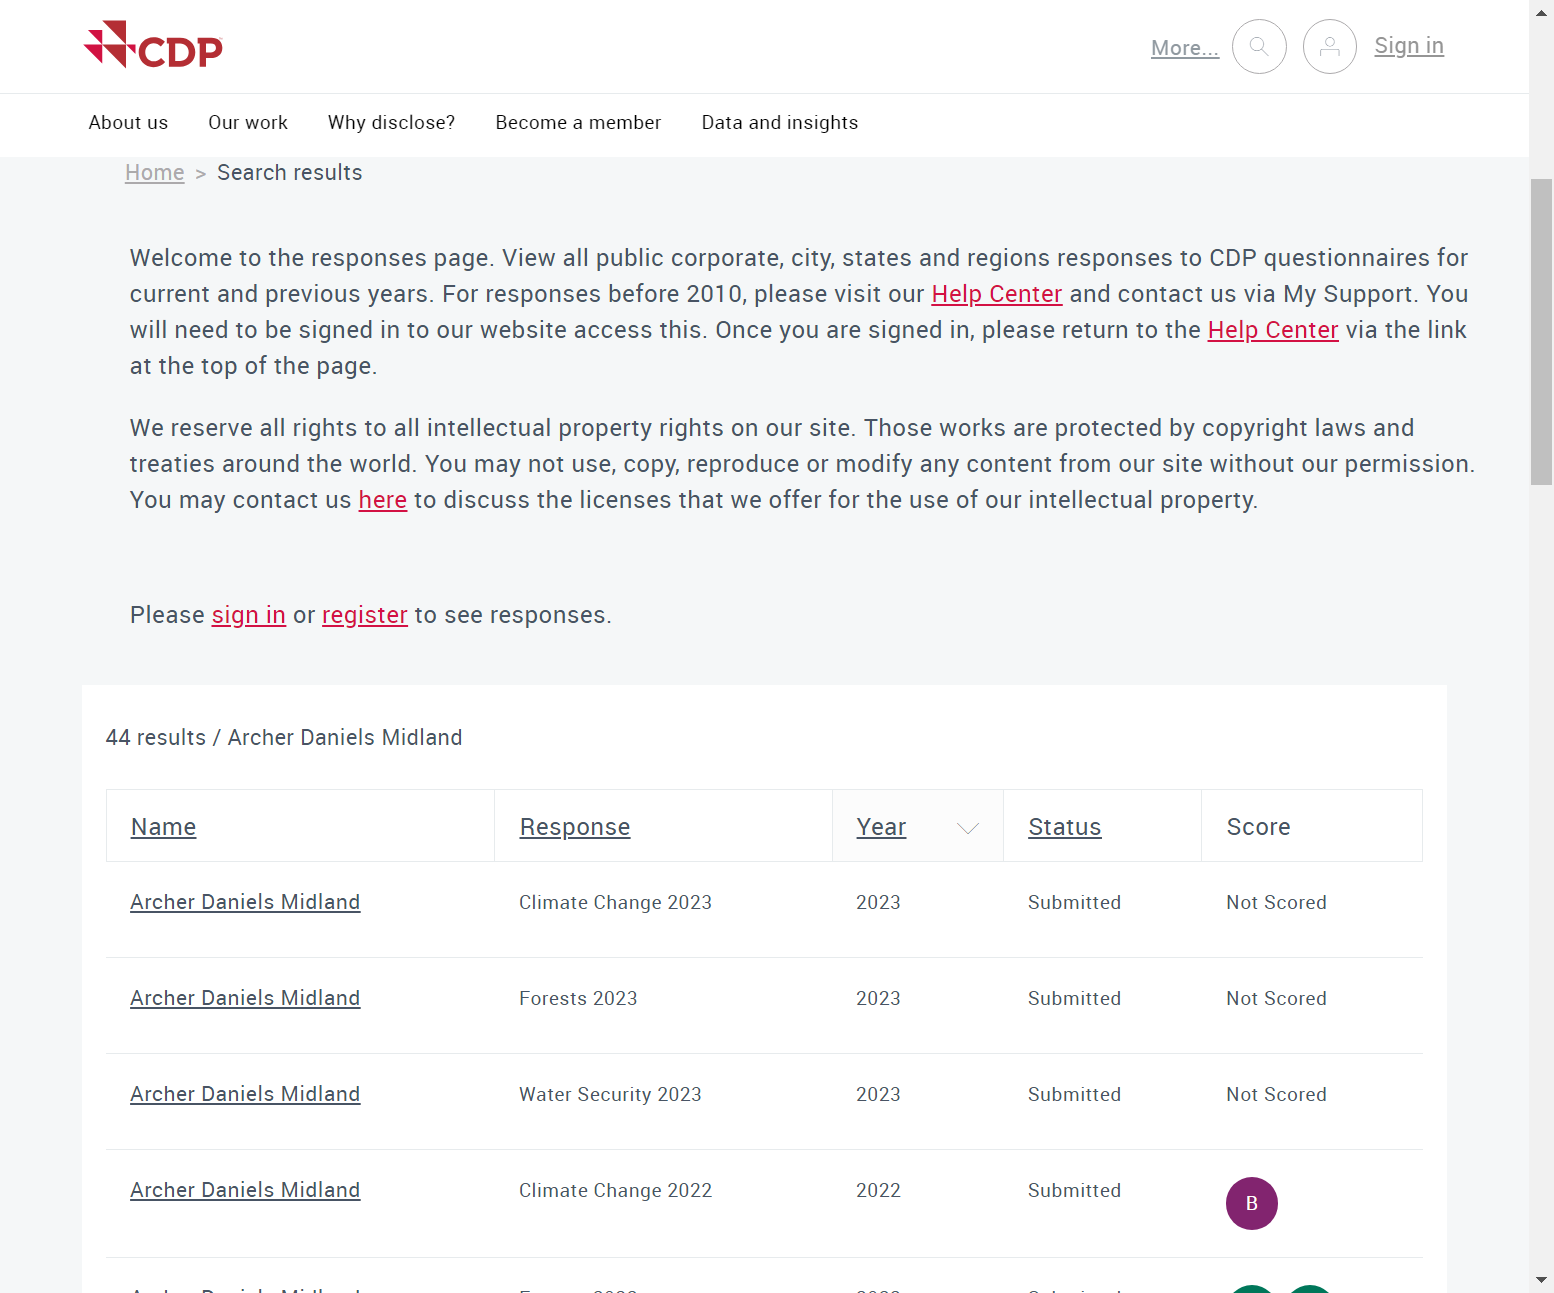

In [33]:
show_screen()

##### 2.3 *scraper(bot, year, company_name)*

The scraper() function specified the year of the company data. Users need to specify the year before implementing this function. This function would return a table containing the response link to each questionnaire.

In [34]:
def scraper(bot, year, company_name):
    time.sleep(1)
    # Use WebDriverWait for a more efficient wait
    try:
        WebDriverWait(bot, 5).until(EC.presence_of_element_located((By.ID, "challenge-stage"))).click()
    except NoSuchElementException:
        pass  # If the element is not found, do nothing and continue
    except TimeoutException:
        pass  # If the wait times out, do nothing and continue

    # Find the table by its class name (or other suitable selector)
    table = bot.find_element(By.CLASS_NAME, "sortable_table")

    # Extract all rows from the table
    rows = table.find_elements(By.TAG_NAME, "tr")

    # Initialize lists to store data and hrefs
    data = []
    hrefs = []

    # Extract data from each row
    for row in rows[1:]:  # Skip the header row
        cols = row.find_elements(By.TAG_NAME, "td")
        row_data = []
        row_hrefs = []
        for i, col in enumerate(cols):
            links = col.find_elements(By.TAG_NAME, "a")
            if links:
                # Extract text and href for each link
                link_text = links[0].text
                link_href = links[0].get_attribute('href')
                row_data.append(link_text)
                row_hrefs.append(link_href)
            else:
                # If no link, add the text and a None for href
                row_data.append(col.text)
                row_hrefs.append(None)
        
        data.append(row_data)
        hrefs.append(row_hrefs)

    # Create a DataFrame from the extracted data
    column_headers = [col.text for col in rows[0].find_elements(By.TAG_NAME, "th")]
    df = pd.DataFrame(data, columns=column_headers)

    # Add the hrefs as a new column
    df['Response Links'] = pd.Series([href[1] for href in hrefs])

    df = df[df['Year'] == year]
    df = df[df['Name'].str.contains(company_name, case=False)]

    return df

Example: Scraping the data of ADM in year 2023.

In [ ]:
year = '2023'
company_name = 'Archer Daniels Midland'
df = scraper(bot, year, company_name)

##### 2.4 *find_section(row)*

The find_section() function creates several bots to visit the response links of each companies. By visiting, parsing, and formulating the text of each response link, it returns a dataframe containing a section of the text as an overview that introduces users to the company's sustainability initiatives.

In [35]:
def find_section(row):

    try:
        WebDriverWait(bot, 5).until(EC.presence_of_element_located((By.ID, "challenge-stage"))).click()
    except NoSuchElementException:
        time.sleep(10)  # If the element is not found, do nothing and continue
    except TimeoutException:
        time.sleep(10)  # If the wait times out, do nothing and continue

    if 'Climate Change' in row['Response']:
        bot.get(row['Response Links'])

        WebDriverWait(bot, 10).until(EC.visibility_of_element_located((By.ID, 'formatted_responses_section_31715')))
        scraped_text = bot.find_element(By.ID, 'formatted_responses_section_31715').text

    elif 'Forest' in row['Response']:
        bot.get(row['Response Links'])

        WebDriverWait(bot, 10).until(EC.visibility_of_element_located((By.ID, 'formatted_responses_section_90809')))
        scraped_text = bot.find_element(By.ID, 'formatted_responses_section_90809').text    

    elif 'Water Security' in row['Response']:
        bot.get(row['Response Links'])

        WebDriverWait(bot, 10).until(EC.visibility_of_element_located((By.ID, 'formatted_responses_section_31639')))
        scraped_text = bot.find_element(By.ID, 'formatted_responses_section_31639').text   

    else:
        scraped_text = 'Unknown Response Type'

    return scraped_text

    
def apply_scraping(df):
    global bot, company_name

    try:

        df['text'] = df.apply(find_section, axis=1)

    except Exception:
        df['text'] = ''
        
    return df 

In [ ]:
df = apply_scraping(df)

##### 2.5 *merge_table(tb1, tb2)*

This function allows users to merge the tables of different companies.

Example: Create an empty dataframe and merge different companies' data to it.

In [36]:
sus = pd.DataFrame()
def merge_table(tb1, tb2):
    return pd.concat([tb1, tb2], axis = 0)

In [ ]:
sus = merge_table(sus, df)

#### 3. Important Note

CDP website has an extremely strict anti-bot mechanism that was designed to counter DDoS attack. Therefore, for users' sake, we suggest accessing data for one company, then waiting for 5 minutes before moving to the next each time to avoid the hCaptcha blocking the bot.

For more details about the hcaptcha, please refer to `hcaptcha.jpg` under the same path.